# Predicting MBA scores from Bachelor’s, Higher Secondary, and Secondary Scores

This notebook contains the code used for correlation and regression analyses. I highly recommend reading the report I wrote (available upon request on [LinkedIn](https://linkedin.com/in/kyurikotpq)) first, or simultaneously, as the report motivates the code.

## Import the data

First, we will import the data using Pandas and, using `df.info()`, obtain information about the columns and their data types. `df.info()` also helps us check for any missing values.

In [170]:
# Import useful packages
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as statsmodels # useful stats package with regression functions
import matplotlib.pyplot as plt
import seaborn as sns # very nice plotting package

# style settings
sns.set(color_codes=True, font_scale = 1.1)
sns.set_style("whitegrid")

# Import the data
df = pd.read_csv("./placement_data.csv") 

# Get information about the columns and their 
# data types, including any missing values if any
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


In [171]:
# Display first five rows of dataset
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


### Observations

The dataset is clean, with little missing values except for the `salary` column.

The columns can be explained as follows:
```
DataFrame Column Name   |  Variable Name/Purpose 
------------------------|--------------------------
sl_no                   |  Unique Identifier
gender                  |  Participant Gender
ssc_p                   |  Participant Secondary School Score (Percentage)
ssc_b                   |  Participant Secondary School Board
hsc_p                   |  Participant Higher Secondary School Score (Percentage)
hsc_b                   |  Participant Higher Secondary School Board
hsc_s                   |  Participant Higher Secondary School Stream
degree_p                |  Participant Bachelor's Score (Percentage)
degree_t                |  Participant Bachelor's Industry
workex                  |  Participant Work History
etest_p                 |  
specialisation          | 
mba_p                   | 
status                  | 
salary                  | 
```


## Correlation & Simple Regression Analysis
### Checking if conditions for correlation analysis are met

These conditions should be met before we can conduct a correlation analysis:
1. `mba_p` and `degree_p` should show a linear trend
2. There is constant variability (homoscedasticity) in the data
3. There are minimal outliers in the data

To verify these conditions, we will construct a scatterplot of the two variables:


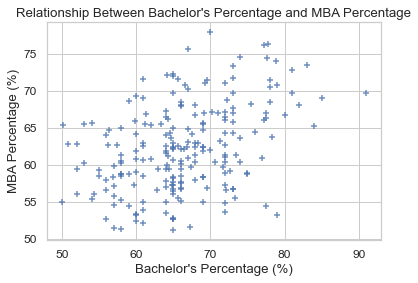

In [172]:
# ACKNOWLEDGEMENT: The code in this cell is adapted from
# the code provided in CS51 Session 1

# Plot a basic scatterplot with/without a trend line
#
# @param {String} x — the column name for the predictor variable
# @param {String} x_label — the label for the x axis
# @param {String} y — the column name for the response variable
# @param {String} y_label — the label for the y axis
# @param {String} title — the title of the scatterplot
# @param {Boolean} fit_reg — whether to fit a regression line
# @param {DataFrame} df — the Pandas DataFrame containing the data
# @param {Tuple} eqn — the Tuple containing the equation of the 
# regression model, slope, and intercept (in this order)
def scatterplot(x, x_label, y, y_label, title, df, eqn = None):
    # Create the scatterplot
    ax = sns.regplot(
        x=x,
        y=y,
        marker="+",
        data=df,
        fit_reg=False)

    # Axis labels and plot title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    # If we want to display an equation 
    # along with the regression line
    if eqn is not None:
        # Plot the regression line
        slope = eqn[1]
        intercept = eqn[2]
        ax.plot(df[x], (slope * df[x]) + intercept)

        # Calculate the coordinates for the top RH corner
        eqn_str = f"{y} = {slope} * {x} + {intercept}"
        top_RH_x = 0.85 * df[x].max()
        top_RH_y = slope * df[x].max() + intercept + 2.5

        # Display the Equation
        text = ax.text(top_RH_x, top_RH_y, eqn_str)

        # This line of code is obtained from 
        # https://stackoverflow.com/questions/23696898/adjusting-text-background-transparency
        text.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    plt.show()

# Call the function without the regression line
scatterplot("degree_p", "Bachelor's Percentage (%)",
            "mba_p", "MBA Percentage (%)",
            "Relationship Between Bachelor's Percentage and MBA Percentage",
            df)


From the scatterplot, we can see from the "football-shaped" data that there is a positive linear trend between the two variables, with homoscedasticity and minimal outliers. Hence, we can proceed with our correlation analysis.

### Conducting a Correlation Analysis

In [173]:
# ACKNOWLEDGEMENT: The code in this cell is adapted from
# the code provided in CS51 Session 1

# Calculate the means and standard deviations of the 
# predictor and response variables and the Pearson's 
# correlation value for these two variables.
#
# Then, print these values. 
# 
# The data should be in a Pandas DataFrame
#
# @param {String} x — the column name for the predictor variable
# @param {String} x_label — the label for the x axis
# @param {String} y — the column name for the response variable
# @param {String} y_label — the label for the y axis
# @param {DataFrame} df — the Pandas DataFrame containing the data
# @return r — Pearson's r
def p_corr(x, x_label, y, y_label, df):
    # Calculate the Pearson's r value 
    # (rounding to 3 decimal places)
    r = round(df[x].corr(df[y]), 3)

    # Calculate the means of both variables
    # (rounding to 3 decimal places)
    x_mean = df[x].mean()
    y_mean = df[y].mean()

    # Calculate the SDs of both variables
    # (rounding to 3 decimal places)
    x_std = df[x].std()
    y_std = df[y].std()

    # Print the values
    print(f"\tMean\tStd".expandtabs(10)) # header
    print(f"{x}\t{round(x_mean, 3)}\t{round(x_std, 3)}".expandtabs(10))
    print(f"{y}\t{round(y_mean, 3)}\t{round(y_std, 3)}".expandtabs(10))
    print("")
    print("Pearson's r value comparing",
          x_label, f"({x})\nto", y_label, f"({y}):", r, "\n")

    return r


# Call the function for our two variables
r = p_corr("degree_p", "Bachelor's Percentage (%)",
       "mba_p", "MBA Percentage (%)", df)


          Mean      Std
degree_p  66.37     7.359
mba_p     62.278    5.833

Pearson's r value comparing Bachelor's Percentage (%) (degree_p)
to MBA Percentage (%) (mba_p): 0.402 



### Checking Conditions for Constructing a Simple Regression Model
Additional conditions must be met before we can construct and analyze a simple regression model for two correlated variables within a sample:
1. The residuals—errors between the predicted value and observed actual value—are nearly normal
2. The observations are random and independent of each other

To verify the first condition, we will construct residual plots and normal probability plots for our least squares regression line:


In [174]:
# ACKNOWLEDGEMENT: The code in this cell is adapted from
# the code provided in CS51 Session 2 and 4

# This function conducts a simple OR multiple regression analysis by:
# 1) Creating a scatter plot,
# 2) Creating a residual plot,
# 3) Computing R-squared
# 4) Computing the Regression Eqn (using the statsmodels library)
#
# @param {String|String[]} column_x — The predictor variable(s) column name
# @param {String} x_label — the label for the x axis
# @param {String} column_y — The response variable column name
# @param {String} y_label — the label for the y axis
# @param {String} title — the Title for the scatterplot
# @param {DataFrame} data — The Pandas DataFrame
def multi_regression_model(column_x, x_label, column_y, y_label, title, data):
    things_to_return = [] # For simple regression models

    # fit the regression line using "statsmodels" library
    X = statsmodels.add_constant(data[column_x])
    Y = data[column_y]
    # OLS stands for "ordinary least squares"
    regression_model = statsmodels.OLS(Y, X).fit()

    # extract regression parameters from model, rounded to 3 decimal places:
    R_squared = round(regression_model.rsquared, 3)
    R_squared_adj = round(regression_model.rsquared_adj, 3)

    # Display both R-squared
    print("R-squared:", R_squared)
    print("Adjusted R-squared:", R_squared_adj)


    if type(column_x) is str:
        # extract regression parameters from model, rounded to 3 decimal places:
        slope = round(regression_model.params[1], 3)
        intercept = round(regression_model.params[0], 3)
        eqn = f"{column_y} = {slope} * {column_x} + {intercept}"
        print("Regression equation:", eqn)

        # Scatterplot
        scatterplot(column_x, x_label,
                    column_y, y_label,
                    title, data,
                    (eqn, slope, intercept))

        things_to_return = (eqn, slope, intercept)

    # Residual Plot
    residual_plot = sns.residplot(x=regression_model.predict(), y=column_y, data=data)
    residual_plot.set_ylabel('Residuals')
    residual_plot.set(title = "Residuals VS Fitted Values")
    residual_plot.set_xlabel(f"Fitted values for {x_label}")
    residual_plot.set_ylim(min(regression_model.resid) - 1,
                           max(regression_model.resid) + 1)

    # Histogram of Residuals
    residual_histogram = sns.displot(regression_model.resid, kde=False, color="pink")
    residual_histogram.set_xlabels("Residuals")
    residual_histogram.set(title = "Distribution of Residuals")

    # QQ plot for residuals
    qq_plot = statsmodels.qqplot(regression_model.resid,fit=True,line='45')
    qq_plot.suptitle("Normal Probability (\"QQ\") Plot for Residuals",fontweight='bold',fontsize=14)


    # If there is nothing to return, return the 
    # regression model so that we can call .summary()  on it 
    if len(things_to_return) == 0:
        things_to_return = regression_model

    return things_to_return

R-squared: 0.162
Adjusted R-squared: 0.158
Regression equation: mba_p = 0.319 * degree_p + 41.109


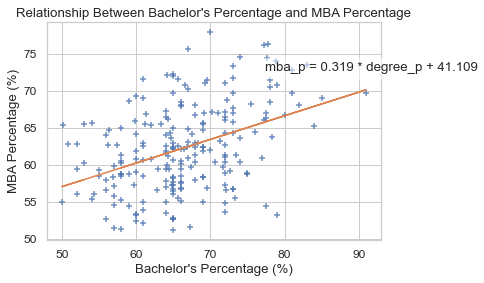

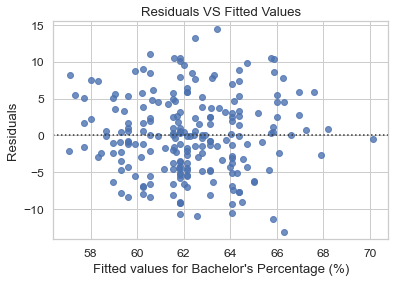

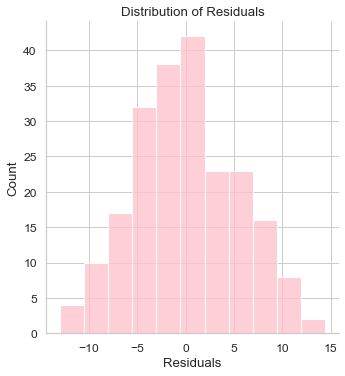

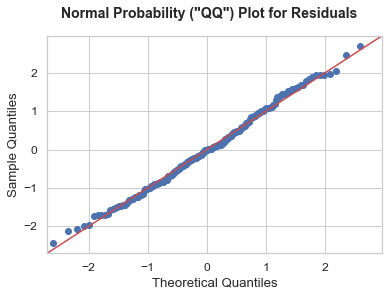

In [175]:
# Fit a simple regression model
# for Bachelor's and MBA Percentage
eqn, b1, b0 = multi_regression_model("degree_p", "Bachelor's Percentage (%)",
                 "mba_p", "MBA Percentage (%)",
                 "Relationship Between Bachelor's Percentage and MBA Percentage",
                 df)        


### Conducting Tests of Statistical Significance on the Slope of the Model

We will only be using hypothesis tests. Confidence Intervals are NOT constructed.

In [176]:
# Calculate the p-value
# @param {Float} sx — Standard deviation of x variable
# @param {Float} sy — Standard deviation of y variable
# @param {Float} r — Pearson's r between x and y
# @param {Integer} n — number of observations in dataset
# @param {Float} b1 — Slope of regression model to evaluate
# @param {Boolean} two_tailed — Whether to conduct a one-tailed or two-tailed test
def calculate_p_value(sx, sy, r, n, b1, two_tailed=True):
    # Calculate the standard error
    SE = (sy/sx) * ((1 - r**2) / (n - 2))**0.5

    # Calculate the t-score
    t = (b1 - 0)/SE

    # Since we want to use cdf,
    # make the t-score always negative
    negative_t = -abs(t)
    percentile = stats.t.cdf(negative_t, n - 2)

    # Calculate the p-value
    p = percentile * 2 if two_tailed else percentile

    # Display the values
    print("Slope, b1:", b1)
    print("Pearson's r:", r)
    print("SE:", SE)
    print("t-score:", t)
    print("p:", p)


# Call the function
calculate_p_value(df["degree_p"].std(),
                  df["mba_p"].std(),
                  r,
                  df["mba_p"].shape[0],
                  b1)


Slope, b1: 0.319
Pearson's r: 0.402
SE: 0.0497338126227611
t-score: 6.414147300945252
p: 9.008614323765065e-10


## Multiple Regression Model Construction and Analysis
### Checking for Suitability of Variables as an Additional Predictor
As mentioned in the report, we will achieve this by producing a pair plot and correlation matrix.

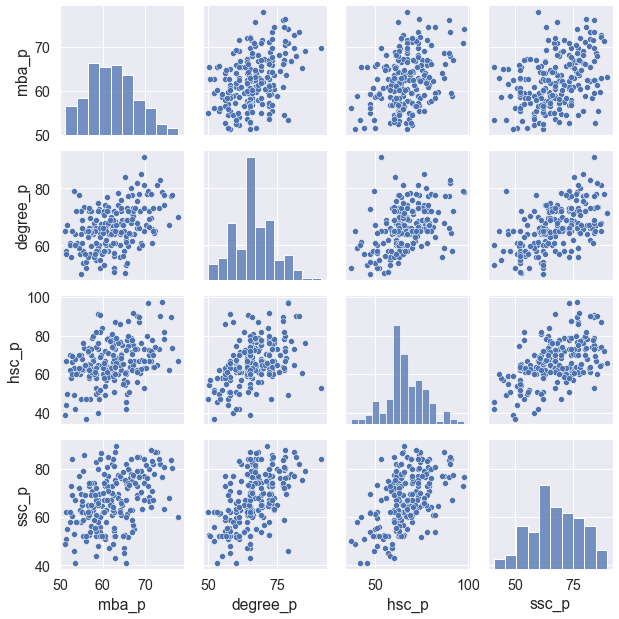

In [186]:
# Our list of columns
COLUMNS = ["mba_p", "degree_p", "hsc_p", "ssc_p"]

# Produce a pair plot where you can see the scatterplot between variables
pair_plot = sns.pairplot(df[COLUMNS], x_vars=COLUMNS, y_vars=COLUMNS, height=2.2)

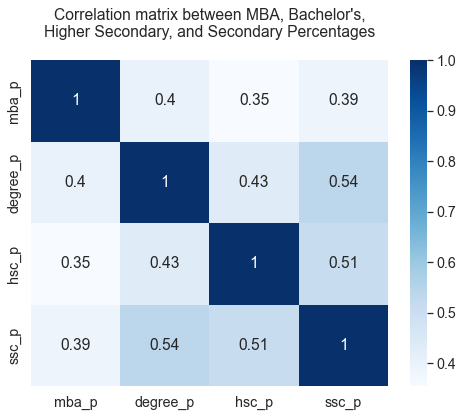

In [184]:
# Produce a correlation matrix to see the 
# correlation coefficients of the different variables

# Get the correlation matrix from Pandas
corrMatrix = df[COLUMNS].corr()

# Format the plot
f, ax = plt.subplots(figsize=(8, 6)) 
sns.set(font_scale=1.3)

# Produce the matrix in the form of a heatmap
# With annotations and Blues color theme
heatmap = sns.heatmap(corrMatrix, annot=True, cmap='Blues')
heatmap.set(title = "Correlation matrix between MBA, Bachelor's,\nHigher Secondary, and Secondary Percentages\n")
plt.show()

### Building Different Multiple Regression Models using Forward Selection
This section shows the different models built using the forward selection strategy for variables.

R-squared: 0.202
Adjusted R-squared: 0.194


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  mba_p   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     26.81
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           4.16e-11
Time:                        09:26:04   Log-Likelihood:                -659.50
No. Observations:                 215   AIC:                             1325.
Df Residuals:                     212   BIC:                             1335.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.2980      3.360     11.397      0.000      31.674      44.922
degree_p       0.2426      0.054      4.492      0.000       0.136       0.349
hsc_p          0.1188      0.036      3.259      0.001       0.047       0.191
==============================================================================
Omnibus:                        5.164   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                3.837
Skew:                           0.199   Prob(JB):                        0.147
Kurtosis:                       2.480   Cond. No.                         889.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

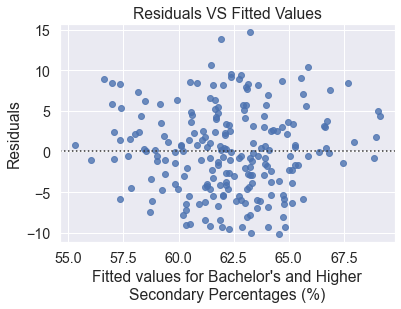

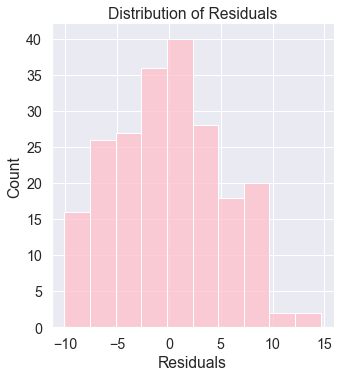

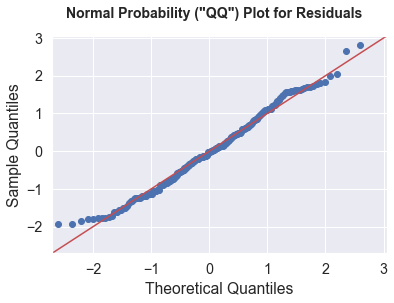

In [179]:
# Predictors: Bachelor's and Higher Secondary Percentage only
model = multi_regression_model(["degree_p", "hsc_p"], 
                "Bachelor's and Higher\nSecondary Percentages (%)",
                 "mba_p", "MBA Percentage (%)",
                 "Relationship Between Bachelor's Percentage and MBA Percentage",
                 df)

model.summary()

R-squared: 0.203
Adjusted R-squared: 0.196


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  mba_p   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     27.08
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           3.36e-11
Time:                        09:26:05   Log-Likelihood:                -659.29
No. Observations:                 215   AIC:                             1325.
Df Residuals:                     212   BIC:                             1335.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.1887      3.296     11.891      0.000      32.693      45.685
degree_p       0.2157      0.058      3.740      0.000       0.102       0.329
ssc_p          0.1304      0.039      3.327      0.001       0.053       0.208
==============================================================================
Omnibus:                        3.536   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.171   Jarque-Bera (JB):                3.031
Skew:                           0.196   Prob(JB):                        0.220
Kurtosis:                       2.570   Cond. No.                         880.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

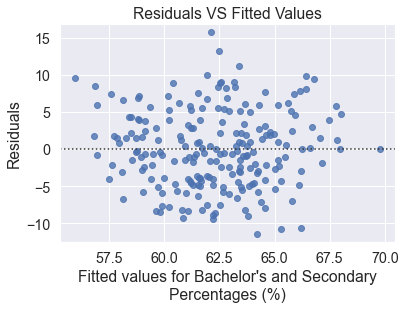

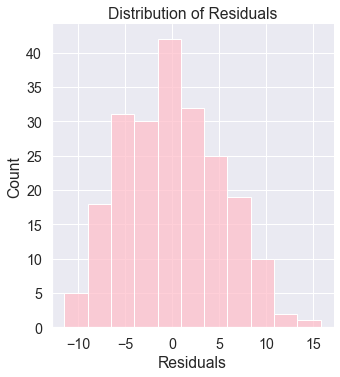

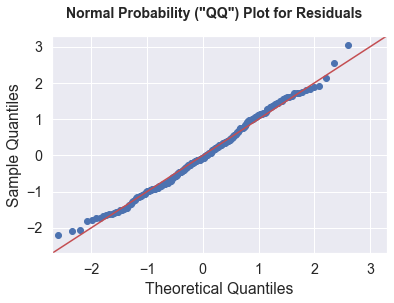

In [180]:
# Predictors: Bachelor's and Secondary Percentage only
model = multi_regression_model(["degree_p", "ssc_p"], 
                "Bachelor's and Secondary\nPercentages (%)",
                 "mba_p", "MBA Percentage (%)",
                 "Relationship Between Bachelor's Percentage and MBA Percentage",
                 df)

model.summary()

R-squared: 0.184
Adjusted R-squared: 0.176


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  mba_p   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     23.89
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           4.40e-10
Time:                        09:26:05   Log-Likelihood:                -661.89
No. Observations:                 215   AIC:                             1330.
Df Residuals:                     212   BIC:                             1340.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.6052      2.587     17.243      0.000      39.506      49.704
hsc_p          0.1132      0.039      2.928      0.004       0.037       0.189
ssc_p          0.1510      0.039      3.883      0.000       0.074       0.228
==============================================================================
Omnibus:                        3.143   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.208   Jarque-Bera (JB):                2.890
Skew:                           0.209   Prob(JB):                        0.236
Kurtosis:                       2.616   Cond. No.                         684.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

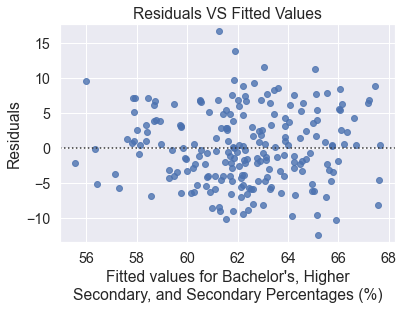

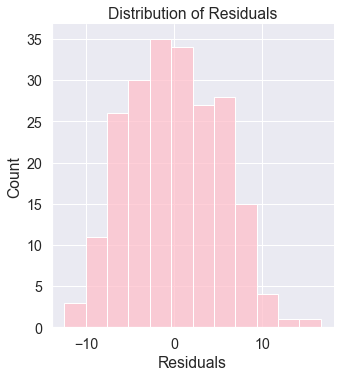

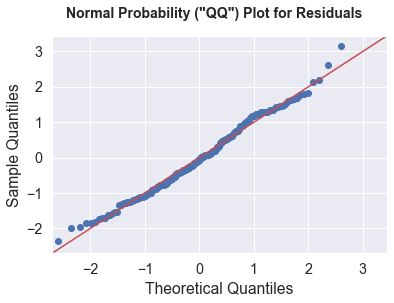

In [181]:
# Predictors: Higher Secondary and Secondary Percentage only
model = multi_regression_model(["hsc_p", "ssc_p"], 
                "Bachelor's, Higher\nSecondary, and Secondary Percentages (%)",
                 "mba_p", "MBA Percentage (%)",
                 "Relationship Between Bachelor's Percentage and MBA Percentage",
                 df)

model.summary()

R-squared: 0.222
Adjusted R-squared: 0.211


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  mba_p   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     20.03
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           1.85e-11
Time:                        09:26:05   Log-Likelihood:                -656.81
No. Observations:                 215   AIC:                             1322.
Df Residuals:                     211   BIC:                             1335.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.6529      3.338     11.280      0.000      31.073      44.233
degree_p       0.1872      0.059      3.197      0.002       0.072       0.303
hsc_p          0.0860      0.039      2.217      0.028       0.010       0.162
ssc_p          0.0965      0.042      2.314      0.022       0.014       0.179
==============================================================================
Omnibus:                        4.144   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                3.420
Skew:                           0.207   Prob(JB):                        0.181
Kurtosis:                       2.541   Cond. No.                     1.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

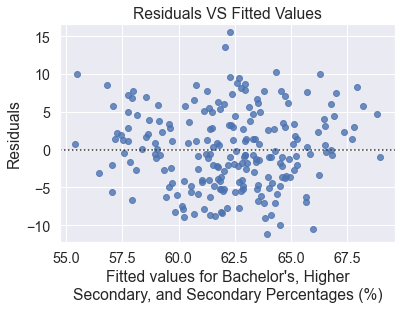

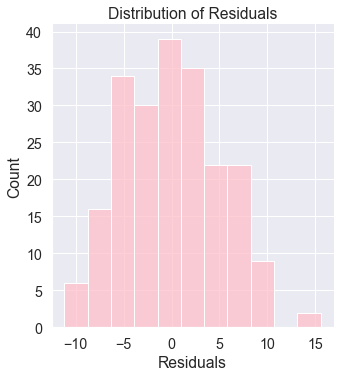

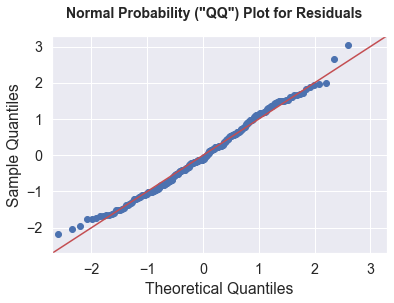

In [182]:
# Predictors: Bachelor's, Higher Secondary, and Secondary Percentage
model = multi_regression_model(["degree_p", "hsc_p", "ssc_p"], 
                "Bachelor's, Higher\nSecondary, and Secondary Percentages (%)",
                 "mba_p", "MBA Percentage (%)",
                 "Relationship Between Bachelor's Percentage and MBA Percentage",
                 df)

model.summary()